### Burst statistics

In [ ]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/vanderbilt")

In [2]:
import os
from functools import partial

import emd
import igraph as ig
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import PyEMD
import scipy
import seaborn as sns
import skimage as ski
import umap
import xarray as xr
from frites.conn.conn_sliding_windows import define_windows
from frites.utils import parallel_func
from mne.time_frequency import tfr_array_morlet
from scipy.optimize import curve_fit
from skimage.segmentation import watershed
from tqdm import tqdm

from config import metadata
from VUDA.emd import emd_vec
from VUDA.io.loadbinary import LoadBinary

/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/umap/distanc

#### Functions

In [3]:
import numba as nb


# @nb.njit
def overlaps(theta_timings: list, gamma_timings: list):
    n_theta = len(theta_timings)
    n_gamma = len(gamma_timings)

    n_overlaps = np.empty(n_gamma, dtype=np.int64)

    for i in range(n_gamma):
        temp = np.logical_and(
            theta_timings[:, 0] - gamma_timings[i, 0] < 0,
            theta_timings[:, 1] - gamma_timings[i, 0] > 0,
        )

        temp = np.logical_and(
            temp,
            np.logical_and(
                theta_timings[:, 0] - gamma_timings[i, 1] < 0,
                theta_timings[:, 1] - gamma_timings[i, 1] > 0,
            ),
        )

        n_overlaps[i] = temp.sum()

    return n_overlaps

In [4]:
def replace_zeros_with_nan(arr):
    """
    Replaces zeros in a JAX array with NaNs.

    Parameters:
        arr (jax.numpy.ndarray): Input array.

    Returns:
        jax.numpy.ndarray: Array with zeros replaced by NaNs.
    """
    return jnp.where(arr == 0, jnp.nan, arr)


def get_n_channels(bursts: np.ndarray, label: int):
    """
    Calculates the maximum number of channels associated with a given label.

    Parameters:
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute channels for.

    Returns:
        int: Maximum number of channels associated with the given label.
    """

    def _for_label(carry, label):
        return (bursts == label).sum(0).max()

    _, out = jax.lax.scan(_for_label, None, labels)
    return np.array(out)


def get_masked_feature(vector: np.ndarray, bursts: np.ndarray, label: int):
    """
    Masks the feature vector based on the given label.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to mask the feature vector.

    Returns:
        numpy.ndarray: Masked feature vector.
    """
    return (bursts == label) * vector


def stats_feature(
    vector: np.ndarray, bursts: np.ndarray, labels: int, fstats=jnp.nanmean
):
    """
    Computes the average of non-zero elements in the masked feature vector, replacing zeros with NaNs.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the average for.

    Returns:
        float: Average of non-zero elements in the masked feature vector.
    """

    def _for_label(carry, label):
        masked = get_masked_feature(vector, bursts, label)
        return carry, fstats(replace_zeros_with_nan(masked))

    _, out = jax.lax.scan(_for_label, None, labels)
    return out


def get_spread(nobs: int, bursts: np.ndarray, labels: int, axes: tuple):
    """
    Computes the spatial spread of a particular label.

    Parameters:
        nobs (int): Number of channels.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the spatial spread for.

    Returns:
        numpy.ndarray: Array containing the minimum and maximum channel indices.
    """

    def _for_label(carry, label):
        out = jnp.nonzero((bursts == label).sum(axes), size=nobs, fill_value=jnp.nan)[0]
        ci, cf = jnp.nanmin(out), jnp.nanmax(out)
        return carry, jnp.array([ci, cf])

    _, out = jax.lax.scan(_for_label, None, labels)

    return out

In [183]:
def get_stats_feature_blocks(
    blocks: np.ndarray, vector: np.ndarray, bursts: np.ndarray, fstats=jnp.nanmean
):
    nblocks = len(blocks)
    bursts = jnp.array(bursts, dtype=jnp.int16)
    max_labels = bursts.max((1, 2, 3))
    max_label = max_labels.max()

    def _for_block(carry, block):
        burst_array = bursts[block]
        labels = jnp.unique(burst_array, size=max_label, fill_value=-1)[1:]
        out = stats_feature(vector, burst_array, labels, fstats)
        return carry, out

    _, out = jax.lax.scan(_for_block, None, blocks)
    jax.device_put(out, jax.devices("cpu")[0])
    #out = [out[i, 0 : max_label[i]] for i in range(nblocks)]
    return out


def get_spread_blocks(blocks: np.ndarray, nobs: int, bursts: np.ndarray, axes: tuple):

    nblocks = len(blocks)
    bursts = jnp.array(bursts, dtype=jnp.int16)
    max_labels = bursts.max((1, 2, 3))
    max_label = max_labels.max()

    def _for_block(carry, block):
        burst_array = bursts[block]
        labels = jnp.unique(burst_array, size=max_label, fill_value=-1)[1:]
        return carry, get_spread(nobs, burst_array, labels, axes)

    _, out = jax.lax.scan(_for_block, None, blocks)
    jax.device_put(out, jax.devices("cpu")[0])
    #out = [out[i, 0 : max_label[i]] for i in range(nblocks)]
    return out

#### Load data

In [171]:
date = "10-20-2022"
monkey = "FN"
max_imfs = None
method = "eemd"

base_path = os.path.expanduser(f"~/funcog/HoffmanData/{monkey}/{date}")

composites_path = os.path.join(
    base_path, "composite_signals_task_method_eemd_max_imfs_None_std_False.nc"
)

ps_composites_path = os.path.join(
    base_path, "ps_composite_signals_task_method_eemd_max_imfs_None_std_False.nc"
)

In [172]:
impath = f"figures/{monkey}/{date}/"

if not os.path.isdir(impath):
    os.makedirs(impath)

In [173]:
composites = xr.open_dataset(composites_path)
ps_composites = xr.open_dataset(ps_composites_path)

In [174]:
channels = list(composites.keys())
nchannels = len(channels)

#### Load burts - one trial

In [175]:
def load_bursts(rythm: str = "slow"):
    assert rythm in ["slow", "fast"]
    _base = os.path.join(base_path, "bursts3D")
    fname = f"labeled_bursts_3d_{rythm}_task_method_eemd_max_imfs_None_std_False.nc"
    fname = os.path.join(_base, fname)
    return xr.load_dataarray(fname)

In [176]:
bursts = (load_bursts(rythm="slow")).astype(np.int16)

In [177]:
nblocks, nchannels, nfreqs, ntimes = bursts.shape
times = bursts.times.data
freqs = bursts.freqs.data

In [178]:
get_spectral_spread = lambda blocks, nfreqs, bursts: get_spread_blocks(
    blocks, nfreqs, bursts, (0, 2)
)
get_temporal_spread = lambda blocks, ntimes, bursts: get_spread_blocks(
    blocks, ntimes, bursts, (0, 1)
)

get_spatial_spread = lambda blocks, nchannels, bursts: get_spread_blocks(
    blocks, nchannels, bursts, (1, 2)
)

In [179]:
features_names = [
    "average(time)",
    "std(time)",
    "temp_spread",
    "average(freq)",
    "sig(freq)",
    "spec_spread",
    "spat_spread",
]

features = {}
for key in features_names:
    features[key] = []

blocks = jnp.asarray(bursts.blocks.data)

mu_time, sig_time = get_stats_feature_blocks(
    blocks, times, bursts.data, fstats=jnp.nanmean
), get_stats_feature_blocks(blocks, times, bursts.data, fstats=jnp.nanstd)

mu_freq, sig_freq = get_stats_feature_blocks(
    blocks, freqs[:, None], bursts.data, fstats=jnp.nanmean
), get_stats_feature_blocks(blocks, freqs[:, None], bursts.data, fstats=jnp.nanstd)

temp_spread = get_temporal_spread(blocks, ntimes, bursts.data)

spec_spread = get_spectral_spread(blocks, ntimes, bursts.data)

spatial_spread = get_spatial_spread(blocks, nchannels, bursts.data)

temp = [
    mu_time,
    sig_time,
    temp_spread,
    mu_freq,
    sig_freq,
    spec_spread,
    spatial_spread,
]

for j, key in enumerate(features_names):
    features[key] = temp[j]

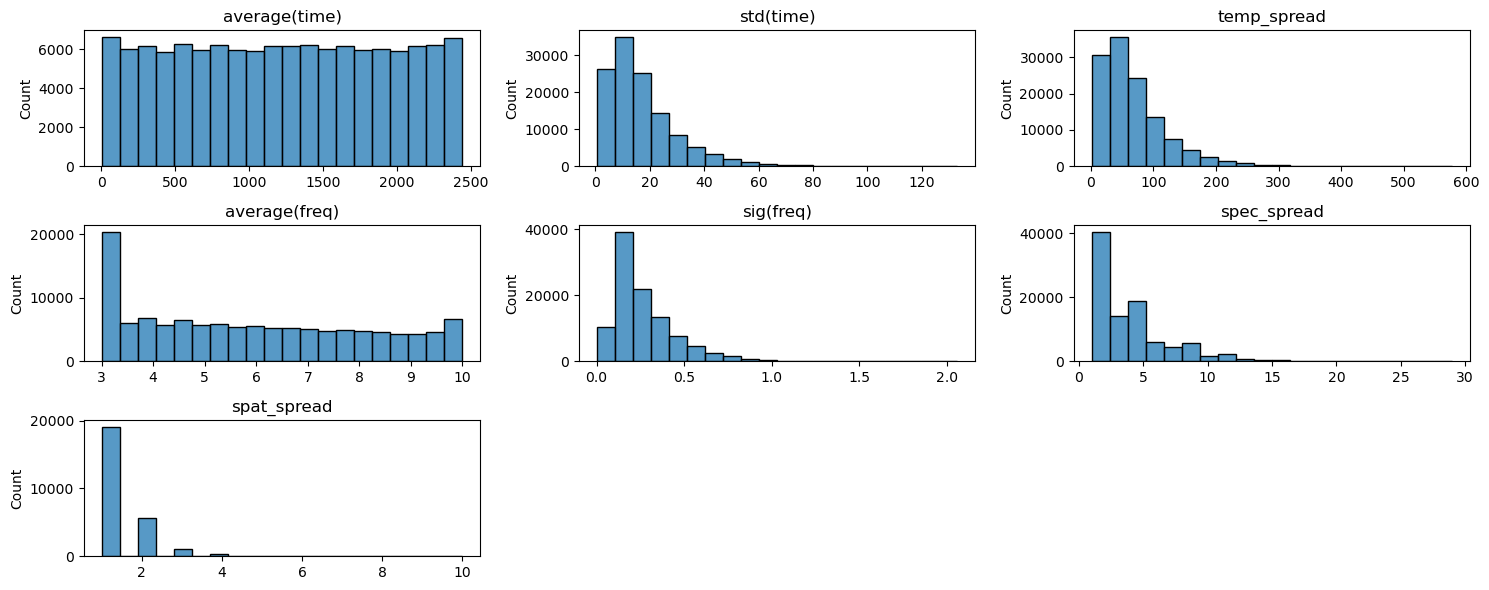

In [59]:
plt.figure(figsize=(15, 6))
for i, key in enumerate(features_names):
    data = features[key].copy()
    if data.ndim == 3:
        data = np.diff(data, axis=2)
    data = data.flatten()
    data = data[~np.isnan(data)]
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=data, bins=20)
    plt.title(key)
plt.tight_layout()

In [254]:
_sel_names = ["average(freq)", "sig(freq)", "spat_spread"]

X = []

for key in _sel_names:
    data = features[key].copy()
    if data.ndim == 3:
        data = np.diff(data, axis=2)
    data = data.flatten()
    data = data[~np.isnan(data)]
    X.append(data.squeeze())
X = np.stack(X).T

In [255]:
idx = np.random.choice(X.shape[0], 50000, replace=True)

In [262]:
reducer = umap.UMAP(n_neighbors=50, n_jobs=20)

In [263]:
X_emb = reducer.fit_transform(X[idx])

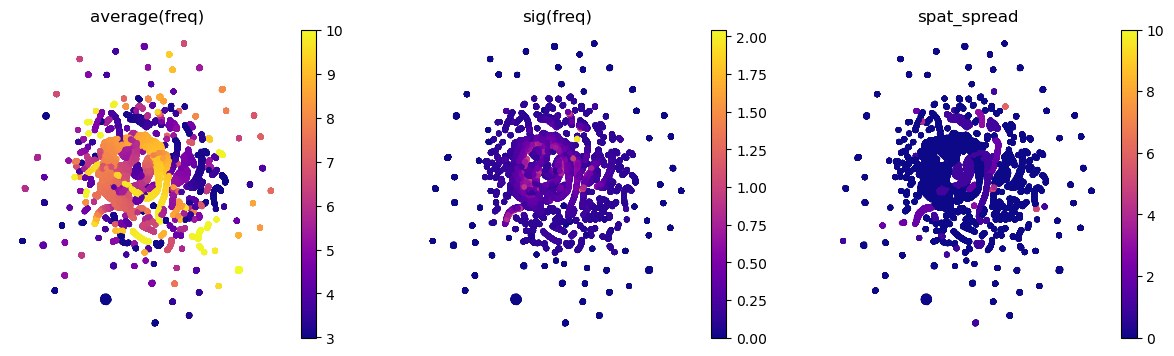

In [265]:
plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(
        X_emb[:, 0], X_emb[:, 1], s=10, c=X[idx, i], cmap="plasma"
    )
    plt.title(_sel_names[i])
    plt.axis("off")
    plt.colorbar()

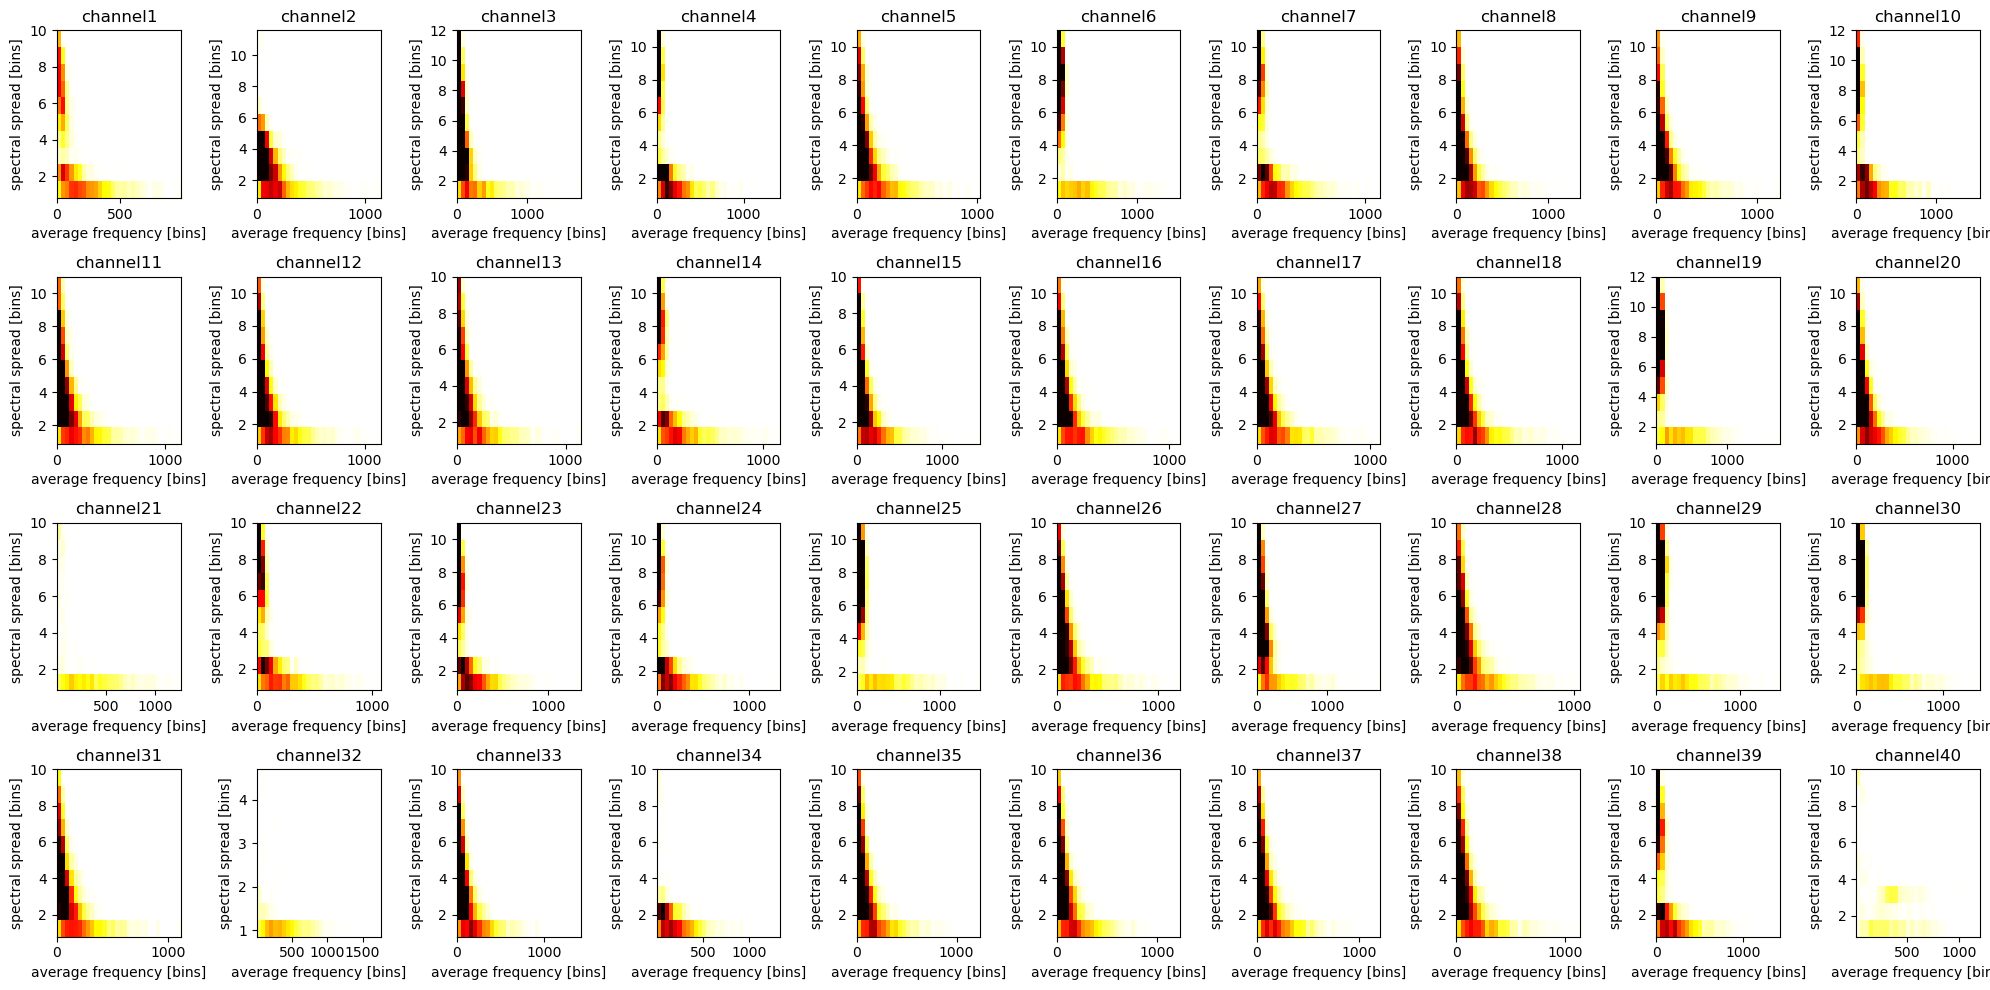

In [37]:
plt.figure(figsize=(20, 10))
for c in range(40):
    plt.subplot(4, 10, c + 1)
    x = features_slow[c][2].flatten()
    y = features_slow[c][4].flatten()
    idx = ~np.logical_or(np.isnan(x), np.isnan(y))
    plt.hist2d(
        x[idx],
        y[idx],
        bins=(30, 10),
        cmap="hot_r",
        vmax=200,
    )
    plt.title(channels[c])
    plt.ylabel("spectral spread [bins]")
    plt.xlabel("average frequency [bins]")
plt.tight_layout()

plt.savefig(os.path.join(impath, "duration_frequency_dist_slow.png"))

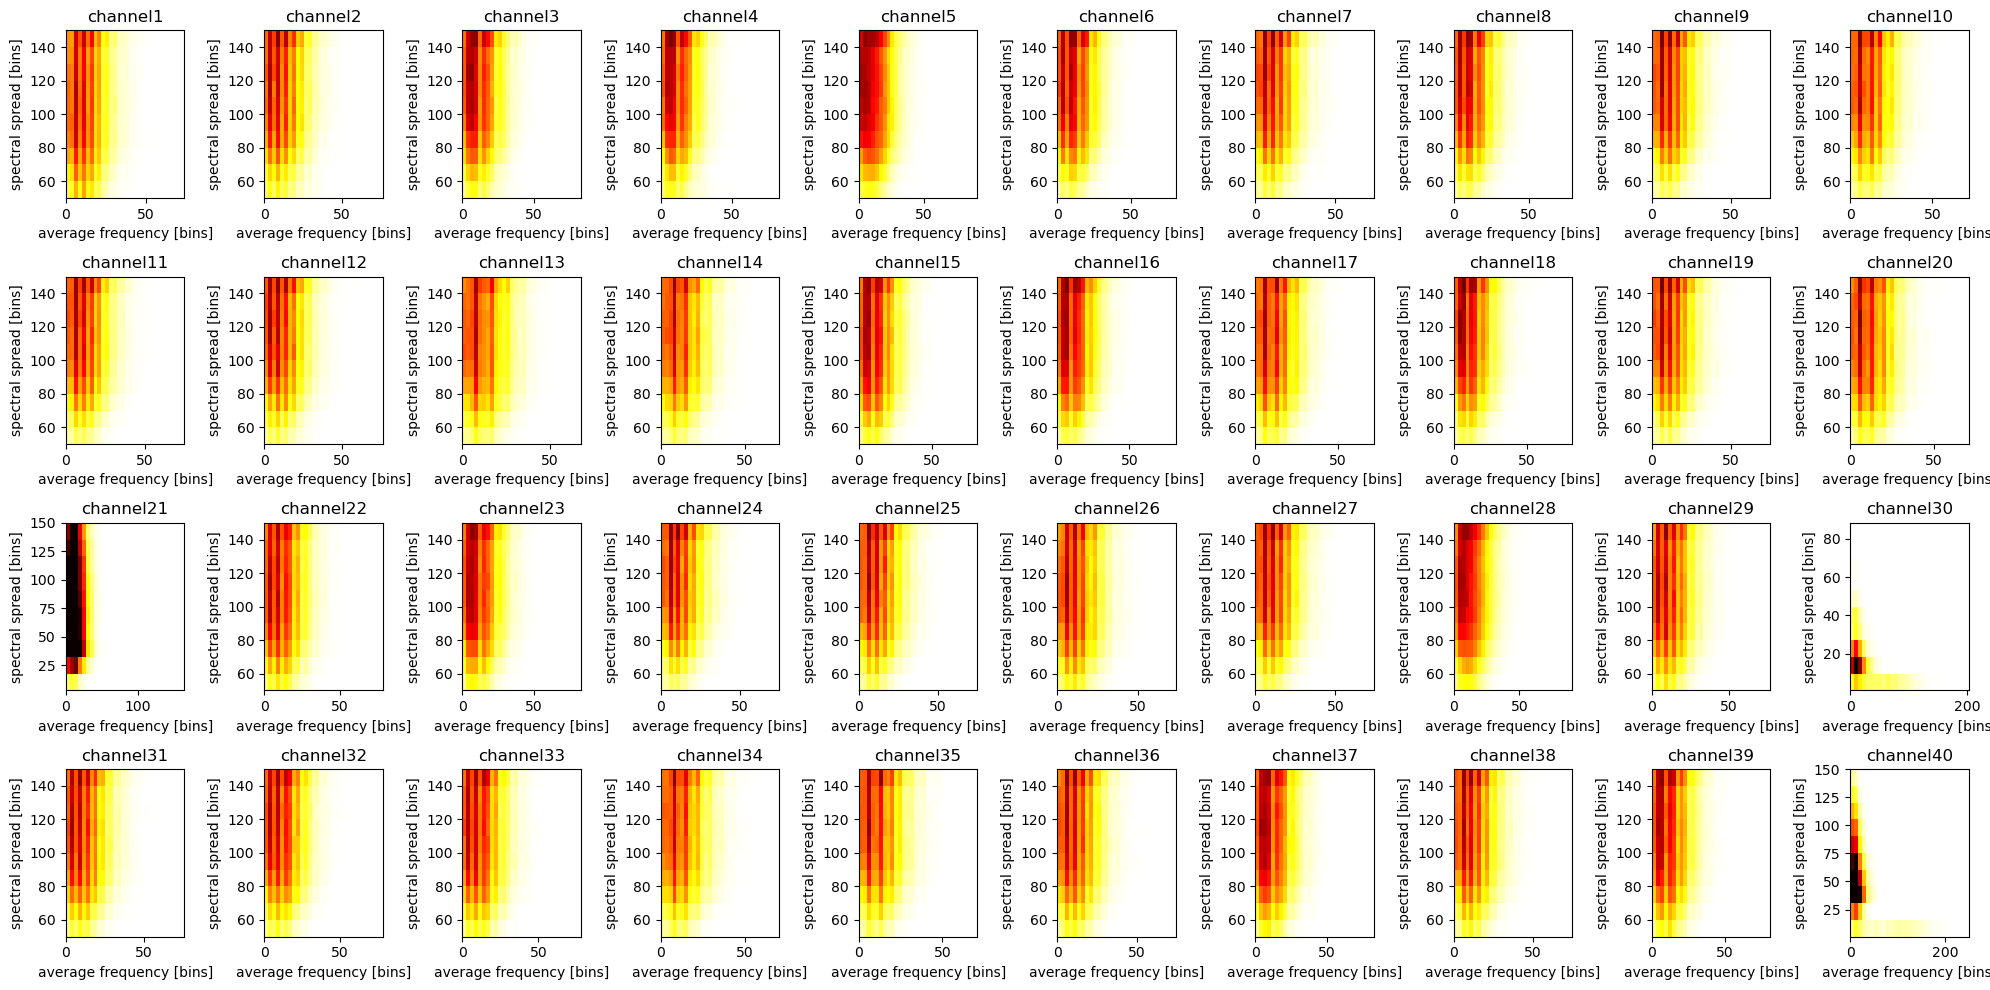

In [38]:
plt.figure(figsize=(20, 10))
for c in range(40):
    plt.subplot(4, 10, c + 1)
    x = temp[c][2].flatten()
    y = temp[c][4].flatten()
    idx = ~np.logical_or(np.isnan(x), np.isnan(y))
    plt.hist2d(
        x[idx],
        y[idx],
        bins=(30, 10),
        cmap="hot_r",
        vmax=2000,
    )
    plt.title(channels[c])
    plt.ylabel("spectral spread [bins]")
    plt.xlabel("average frequency [bins]")
plt.tight_layout()

plt.savefig(os.path.join(impath, "duration_frequency_dist_fast.png"))

In [39]:
def _for_channel(channel):

    slow_timings = features_slow[channel][3]
    fast_timings = temp[channel][3]

    noverlaps = []

    for i in range(200):
        _slow_timings = np.diff(slow_timings[i], axis=1).squeeze()
        _slow_timings = slow_timings[i][_slow_timings > 0, :]

        _fast_timings = np.diff(fast_timings[i], axis=1).squeeze()
        _fast_timings = fast_timings[i][_fast_timings > 0, :]

        noverlaps += [overlaps(_slow_timings, _fast_timings)]

    return np.hstack(noverlaps)

In [40]:
n_overlaps = [_for_channel(channel) for channel in tqdm(range(nchannels))]

100%|█████████████████████████████████████████████████████████| 64/64 [01:06<00:00,  1.04s/it]


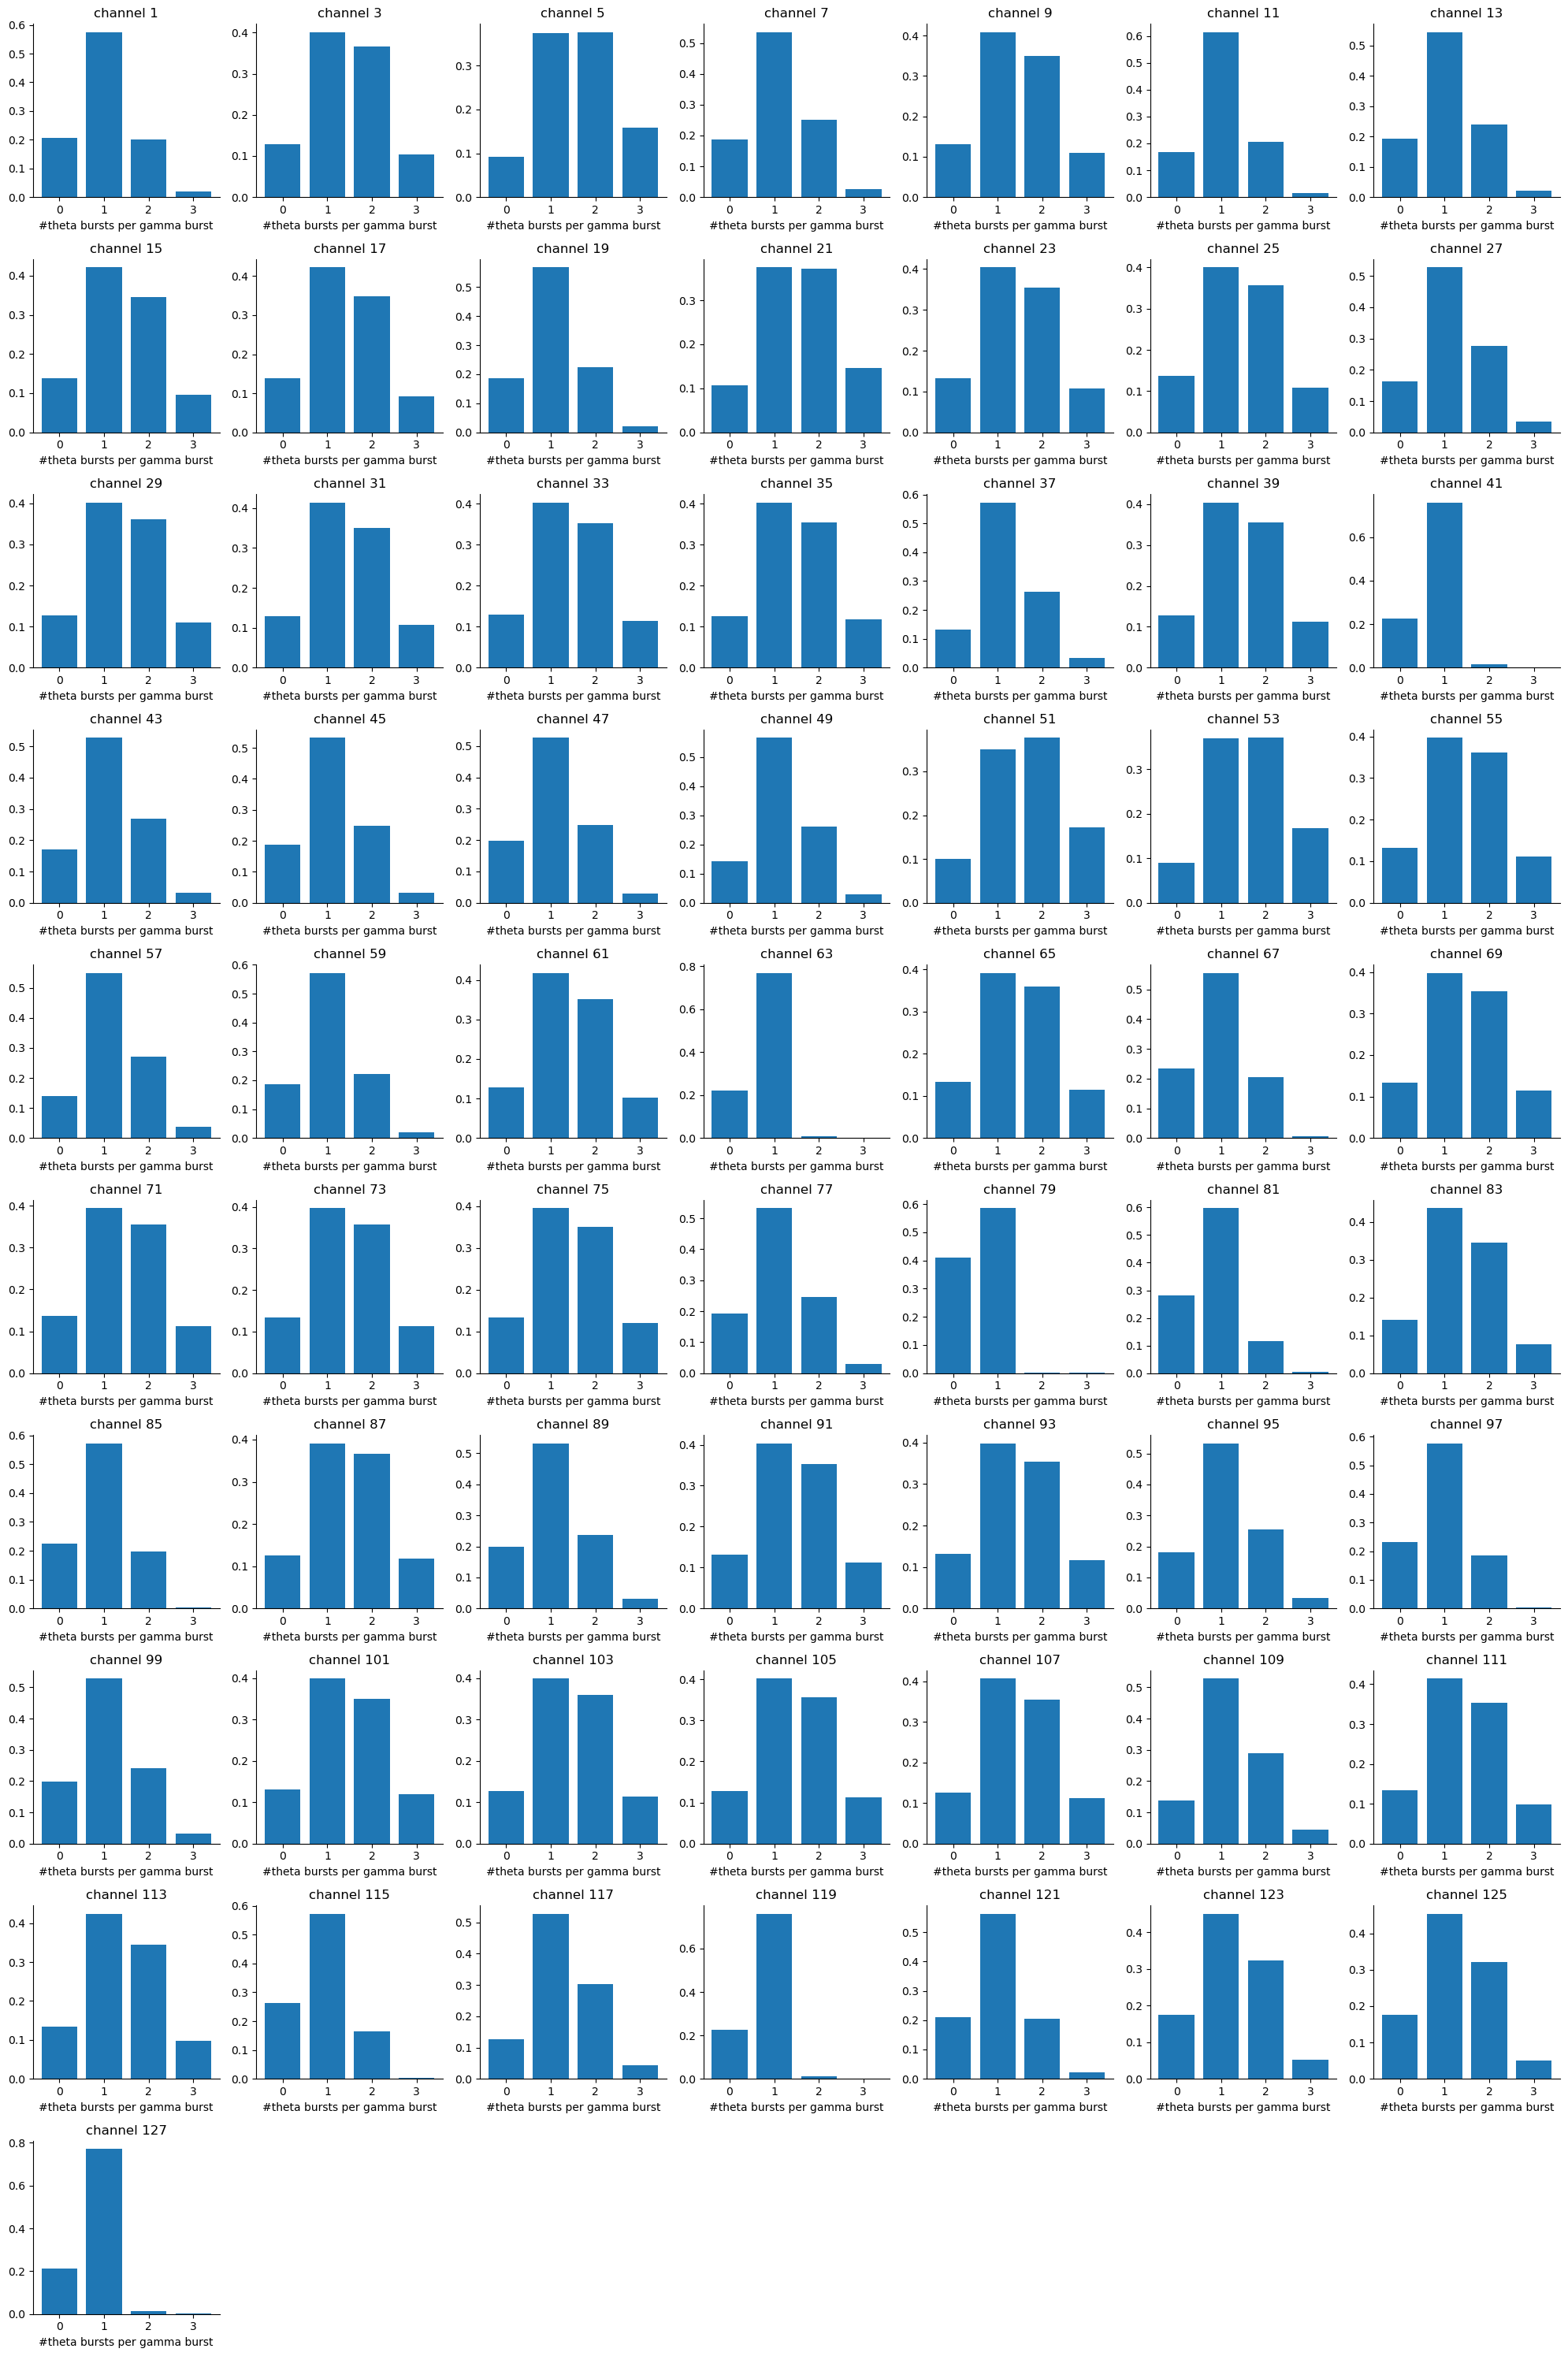

In [48]:
plt.figure(figsize=(20, 30))
pos = 1
for i in range(nchannels):
    ax = plt.subplot(10, 7, i + 1)
    n, x = np.histogram(n_overlaps[i], bins=[0, 1, 2, 3, 4])
    plt.bar(x[:-1], n / n.sum())
    plt.xlabel("#theta bursts per gamma burst")
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.title(f"channel {pos}")
    pos = pos + 2
plt.tight_layout()
plt.savefig(os.path.join(impath, "theta_per_gamma.png"))